In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
from scipy import stats
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil
import sys
sys.path.append("../")

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from PJT_Frustration_Induced_Crystallize.main import *
from multiprocessing import Pool
import pandas as pd

# colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
# cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

SAVE_PATH = r"E:\MS_ExperimentData\general"
MP4_PATH = r"E:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

In [2]:
phaseLags = [0.6 * np.pi]
omegaMins = [0]  # np.linspace(1e-5, 3, 21)
randomSeed = 10
strengthKs = np.linspace(4, 20, 7)  # [20]  # np.linspace(1, 20, 7)
distanceD0s = np.linspace(0.3, 1.1, 7)  #  np.linspace(0.1, 3, 7)  # [1]
deltaOmegas = [0]  # np.linspace(1e-5, 3, 21)  # [1.0]

models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=2000, dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

In [48]:
model = [model for model in models 
      if (model.distanceD0 == distanceD0s[3]) and 
      (model.strengthK == strengthKs[3])][0]
model

PhaseLagPatternFormation(strengthK=12.000,distanceD0=0.700,phaseLagA0=1.885,boundaryLength=7.0,speedV=3.0,freqDist=uniform,omegaMin=0.000,deltaOmega=0.000,agentsNum=2000,dt=0.005,shotsnaps=10,randomSeed=10)

In [3]:
savePath = (
    f"last_state/{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"lastState.h5"
)
modelsNum = len(models)

sas = list()
allPositionX = pd.read_hdf(savePath, key="positionX")
allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

for i, model in enumerate(models):
    sa = StateAnalysis()
    sa.model = model
    sa.totalPositionX = np.array([allPositionX[i]])
    sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
    sas.append(sa)

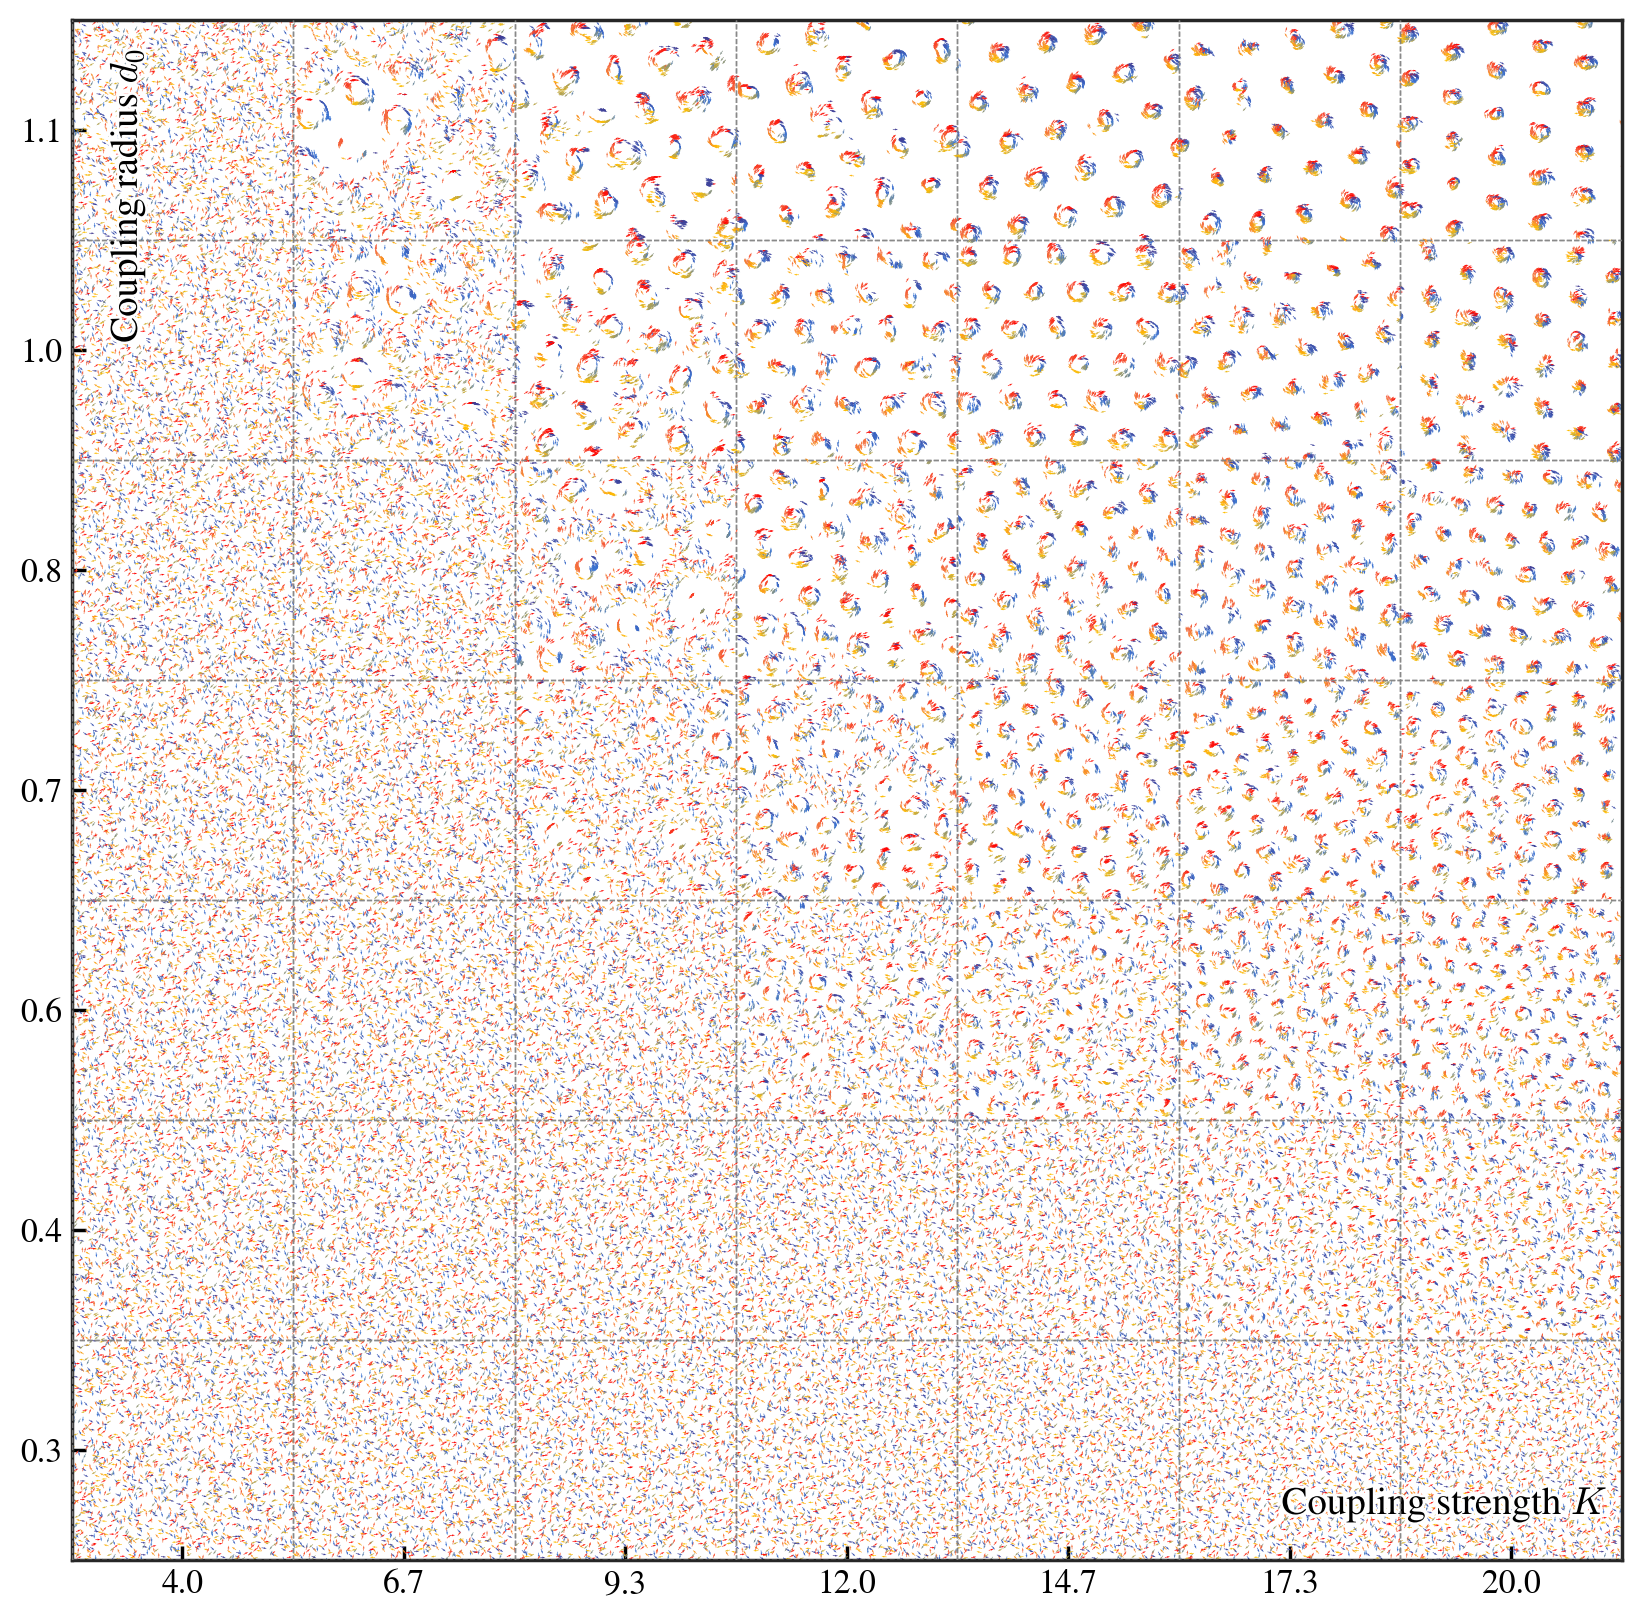

In [6]:
from matplotlib.patheffects import withStroke

colParams = distanceD0s
rowParams = strengthKs
colorsBy = "phase"

# fig, ax = plt.subplots(figsize=(len(rowParams) * 4, len(colParams) * 4))
fig, ax = plt.subplots(figsize=(10, 10))

for i, sa in enumerate(sas):
    if sa is None:
        continue
    row = i // len(rowParams)
    col = i % len(rowParams)
    
    positionShift = np.array([row, col]) * sa.model.boundaryLength
    positionX, phaseTheta = sa.get_state(-1)
    positionX = positionX + positionShift
    if colorsBy == "freq":
        colors = (
            ["red"] * (sa.model.freqOmega >= 0).sum() + 
            ["#414CC7"] * (sa.model.freqOmega < 0).sum()
        )
    elif colorsBy == "phase":
        colors = [cmap(i) for i in
            np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)
        ]

    ax.quiver(
        positionX[:, 0], positionX[:, 1],
        np.cos(phaseTheta), np.sin(phaseTheta), 
        color=colors,
        scale=300, width=0.0004
    )
    ax.axhline(
        y=col * sa.model.boundaryLength, 
        color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
    )
    ax.axvline(
        x=row * sa.model.boundaryLength, 
        color="gray", linewidth=0.5, linestyle="--", alpha=0.3, zorder=100
    )

boundaryLength = models[0].boundaryLength
plt.xlim(0, len(rowParams) * boundaryLength)
plt.ylim(0, len(colParams) * boundaryLength)
plt.xticks(
    np.arange(0, len(rowParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
    [f"{k:.1f}" for k in rowParams]
)
plt.yticks(
    np.arange(0, len(colParams) * boundaryLength, boundaryLength) + boundaryLength / 2,
    [f"{d:.1f}" for d in colParams]
)

text1 = plt.text((len(rowParams) - 0.8) * boundaryLength, 0.25 * boundaryLength,
                 "Coupling strength $K$", # weight="bold",
                 fontsize=14, ha="center", va="center")
text2 = plt.text(0.25 * boundaryLength, (len(colParams) - 0.8) * boundaryLength,
                 "Coupling radius $d_0$", # weight="bold",
                 fontsize=14, ha="center", va="center", rotation=90)
for text in [text1, text2]:
    text.set_path_effects([withStroke(linewidth=2, foreground='white')])
plt.tick_params(length=5, direction="in")
# plt.savefig(
#     f"figs/{sa.model.__class__.__name__}_"
#     f"varying_strengthK_and_distanceD0_{colorsBy}_"
#     f"a{phaseLags[0]:.2f}_Do{deltaOmegas[0]}"
#     f"{'initPhaseTheta,' if sa.model.initPhaseTheta is not None else ''}"
#     f"_aN{sa.model.agentsNum}_dist{sa.model.freqDist}.pdf", 
#     bbox_inches="tight"
# )

In [ ]:
opMap = pd.DataFrame(index=distanceD0s, columns=strengthKs)

for sa in sas:

cellNumInLine = 100
dx = sa.model.boundaryLength / (cellNumInLine - 1)
positionX, _ = sa.get_state(-1)
ocsiIdx = (positionX / dx).round().astype(np.int32)
localCounts = np.zeros((cellNumInLine, cellNumInLine), dtype=np.float64)
for idx in ocsiIdx:
    localCounts[idx[0], idx[1]] += 1
particalDensity = localCounts / localCounts.sum()

# plt.figure(figsize=(6, 6))
# plt.imshow(
#     particalDensity, cmap=cmap, 
#     extent=(0, sa.model.boundaryLength, 0, sa.model.boundaryLength),
#     origin="lower", aspect="equal"
# )

In [41]:
cellNumInLine = 50

opMap = pd.DataFrame(index=distanceD0s, columns=strengthKs, dtype=np.float64)

for sa in sas:

    sa: StateAnalysis

    dx = sa.model.boundaryLength / (cellNumInLine - 1)
    positionX, _ = sa.get_state(-1)
    ocsiIdx = (positionX / dx).round().astype(np.int32)
    localCounts = np.zeros((cellNumInLine, cellNumInLine), dtype=np.float64)
    for idx in ocsiIdx:
        localCounts[idx[0], idx[1]] += 1
    particalDensity = localCounts / localCounts.sum()

    op = np.std(particalDensity.flatten())
    opMap.loc[sa.model.distanceD0, sa.model.strengthK] = op

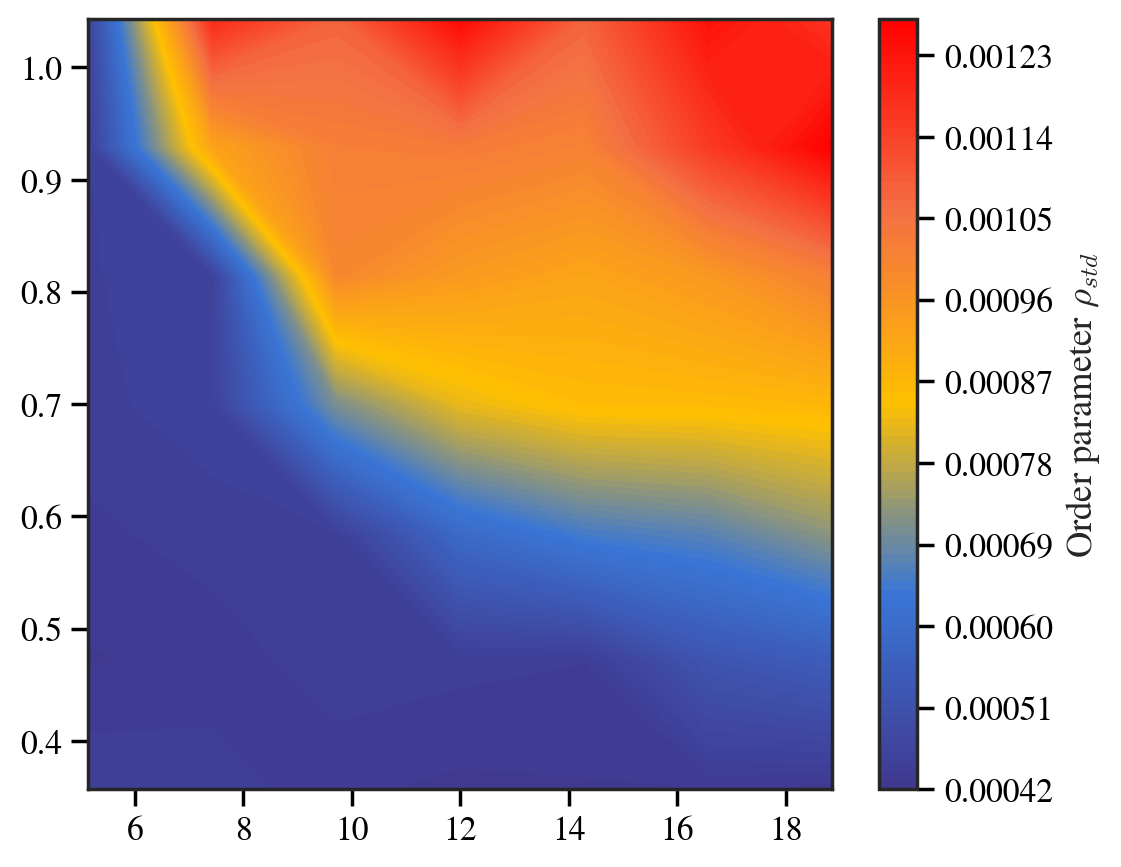

In [47]:
plt.contourf(opMap, 
           cmap=cmap,
           vmin=opMap.values.min(), vmax=opMap.values.max(),
           extent=[opMap.columns.min(), opMap.columns.max(),
                   opMap.index.min(), opMap.index.max()],
           origin="lower", levels=100)
plt.colorbar(label=r"Order parameter $\rho _{std}$")

<Axes: >

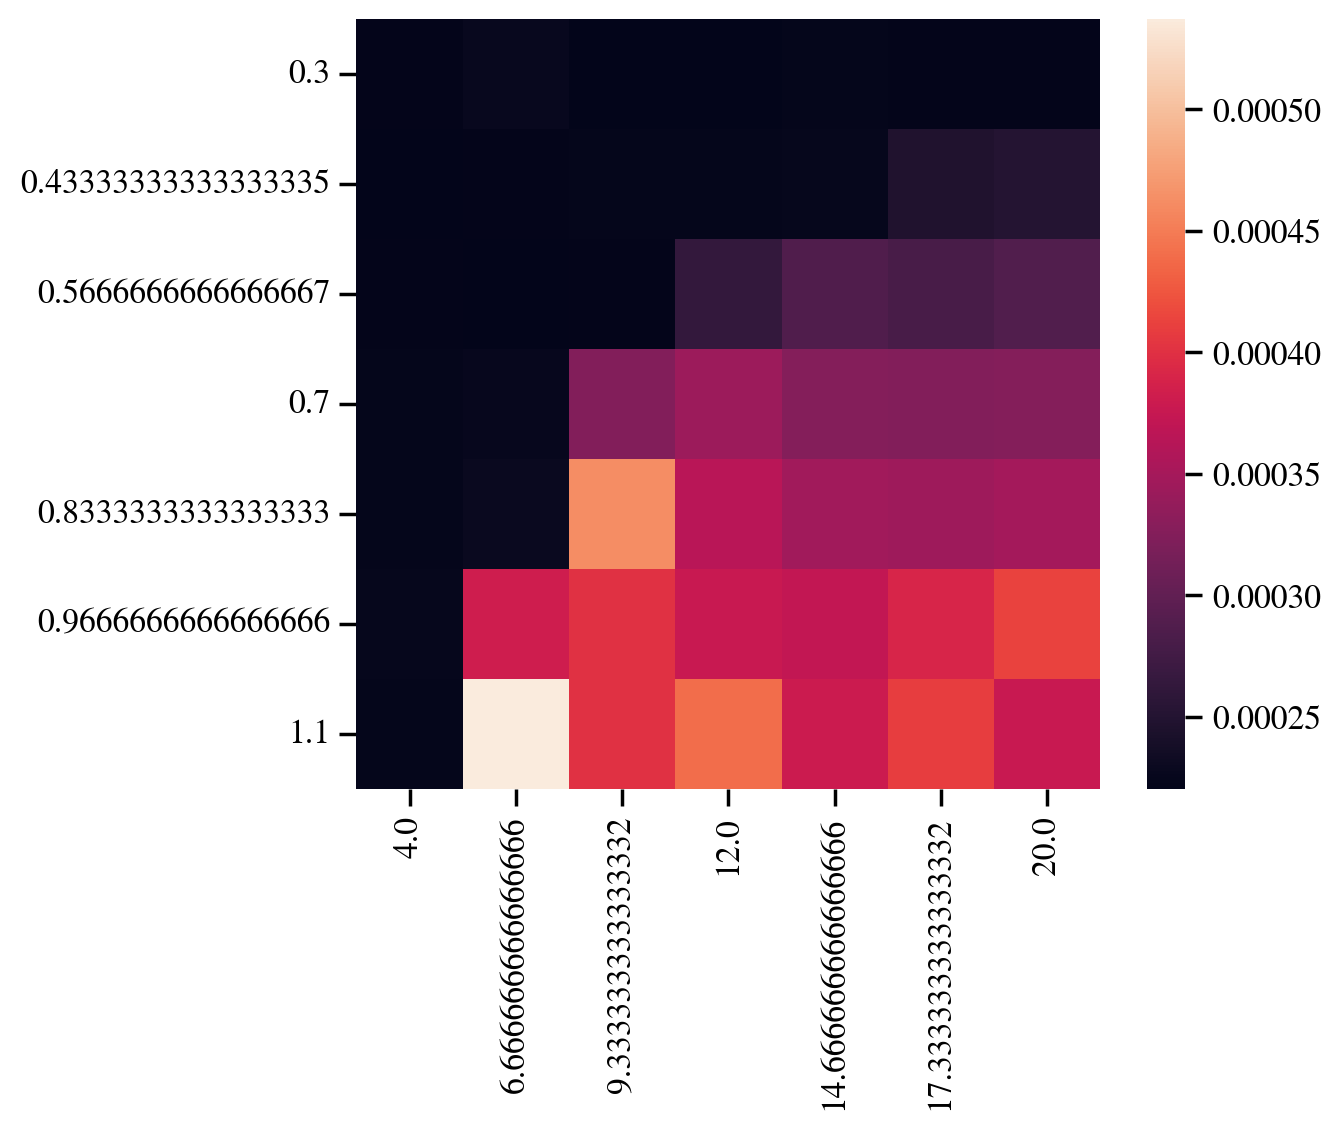

In [24]:
sns.heatmap(opMap)